Project outline:

Define variables. 
Set up system of equations using quaternions. 
See if 3D or 2D animations are computationally possible. 
Show case the mathematics and derivations. (Half for you half for them)
Create some graphs to analyze relationships between satellite shape, orbital eccentricity, and chaos. 

Expand the project: 
include tidal damping and a variable orbit. 

Variables

You have omega = [w1, w2, w3] which tells us the angular velocities of the body about the principal axis of inertia

You have q = [q0, q1, q2, q3] which is the rotation quaternion of the body with respect to an inertial frame. 

You have orbital_radius which dictates the distance between the COM's of the two bodies. we want to assume this is a keplerian orbit first, and then an evolving orbit according to chaotic effects. 

Process:

Find the r vector between the two bodies
    Kepler's Equation give theta and ||r||. Find the r vector point from one body to the other.
    (not ODE, explicit formula using state vector)

Rotate this vector using quaternion multiplication so we know the location of the perturbing body   relative to the satellite's coordinates
    Read off the direction cosines from the rotated vector.
    (not ODE, explicit formula using state vector)

Use the direction cosines and distance to calculate torque.

Use the torque and ODE solver to update the rotation quaternions and angular velocity vector. 

In [1]:
import numpy as np
import kepler
import Quaternion
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

def findEccentericAnomaly(M, e):
    E = M
    for i in range(10):
        
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)

        E = E - f / f_prime
            
    return E #if statements make this super slow

def findOrbialRadius(t, n, a, e):    
    mean_anomaly = n * t #Assume we start at the periapsis
    
    #if we start at some arbitrary true_anomaly, 
    #mean_anomaly = n * t + 2 * np.arctan( np.sqrt((1 - e) / (1 + e)) * np.tan(true_anomaly/2)
                                                                                      
    E = findEccentericAnomaly(mean_anomaly, e) #Solve for the Eccenteric Anomaly
    r = a * (1 - e * np.cos(E)) #calculate the distance
    r_hat = [(np.cos(E) - e) / (1 - e * np.cos(E)),  (np.sqrt(1 - e**2) * np.sin(E)) / (1 - e * np.cos(E)), 0] #calculate the angle vector
    return r, np.array(r_hat)

def findDirectionCosines(r_hat, state):
    q = Quaternion.Quaternion(state[3], -state[4:7]) #Encodes orientation of satellite frame wrt inertial frame
    rotated_bodyframe_r_hat = (q.inverse()*Quaternion.Quaternion(0, [-r_hat[0], -r_hat[1], -r_hat[2]])*q)[1:4] #rotates from global frame to local frame. 
    return rotated_bodyframe_r_hat

def findTorqueVector(mu, r, A, B, C, dCos): 
    scalar = 3 * mu / r**3
    return [scalar * (B-C) * dCos[1] * dCos[2], scalar * (C-A) * dCos[2] * dCos[0],scalar * (A-B) * dCos[0] * dCos[1]]  #Follows from trig in the body frame

#state = omega1, omega2, omega3, q0, q2, q3, q4
def ODE(state, t, G, M, a, e, A, B, C):

    r, r_hat = findOrbialRadius(t, np.sqrt(G * M / a**3), a, e)
    directionCosines = findDirectionCosines(r_hat, state)
    torque = findTorqueVector(G * M, r, A, B, C, directionCosines)
    #Euler's Equations with torque follow quite directly from Lagrangian Mechanics
    omega_dot_1 = ((B-C) * state[1] * state[2] - torque[0]) / A
    omega_dot_2 = ((C-A) * state[2] * state[0] - torque[1]) / B
    omega_dot_3 = ((A-B) * state[0] * state[1] - torque[2]) / C

    #These are relatively simple too. Find the relationship between the time derivative of a quaternion and the angular velocity
    #then carry out quaternion multiplication and equation the components. 
    q_dot_0 = -0.5 * (state[4] * state[0] + state[5] * state[1] + state[6]*state[2])
    q_dot_1 = 0.5 * (state[3] * state[0] - state[6] * state[1] + state[5]*state[2])
    q_dot_2 = 0.5 * (state[6] * state[0] + state[3] * state[1] - state[4]*state[2])
    q_dot_3 = 0.5 * (state[5] * state[0] + state[4] * state[1] - state[3]*state[2])
    return [omega_dot_1, omega_dot_2, omega_dot_3, q_dot_0, q_dot_1, q_dot_2, q_dot_3]


In [3]:
numOrbits = 4
T = numOrbits * 2360000
sampleNumber = 2800

G = 6.67 * 10**-11
M = 5.972 * 10**24
a = 384400000
e = 0.0549
A = .4
B = .4
C = .4

#for the inital velocity (first three) I have it set to not rotate initially. 
#For the initial quaternion, (1, 0, 0, 0) corresponds to the body and grobal frame being alligned, 
#with (cos(x/2), u1 * sin(x/2), u2 * sin(x/2), u3 * sin(x/2)) correspond to the rotation of the
#body frame by an angle x about UNIT vector (u1, u2, u3). 
#The euler angle -> quaternion equation is easily found and can also be used.
state_naught = [0, 0, 0, 1, 0, 0, 0] 

timePoints = np.linspace(0, T, sampleNumber) 

#sol = integrate.odeint(func=ODE, y0=state_naught, t=timePoints, args=(G, M, a, e, A, B, C))

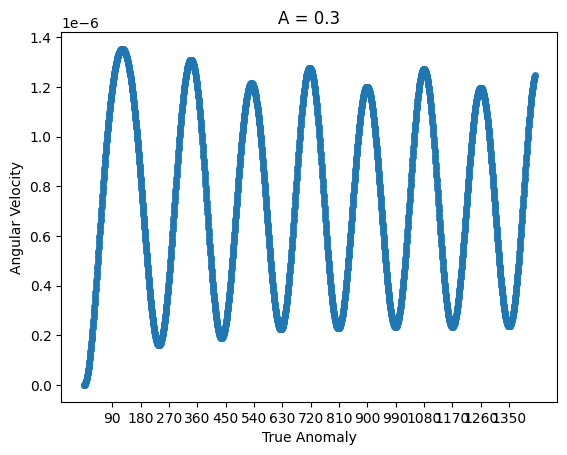

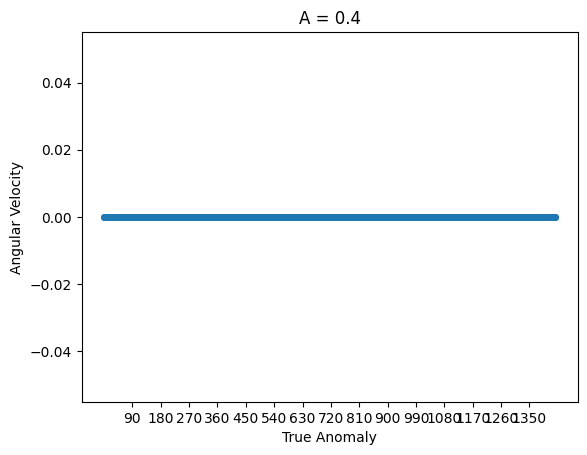

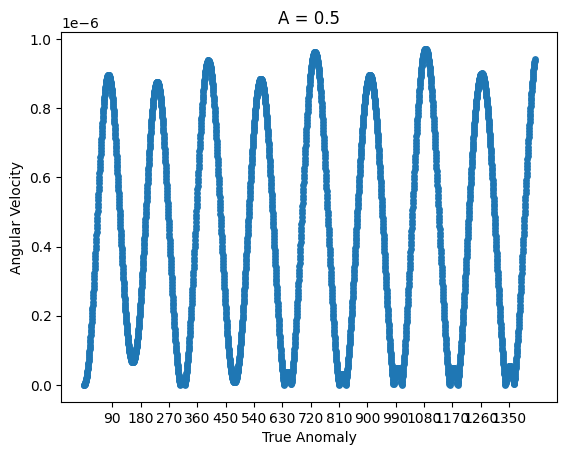

In [4]:
A = [0.3, 0.4, 0.5]
for i in range(3):
    sol = integrate.odeint(func=ODE, y0=state_naught, t=np.linspace(0, T, sampleNumber), args=(G, M, a, e, A[i], B, C))
    
    Mean_Anomaly = np.sqrt(G * M / a**3) * timePoints
    E = findEccentericAnomaly(Mean_Anomaly, e)
    nu_array = np.unwrap(2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), np.sqrt(1 - e) * np.cos(E/2)))
    nu_array = nu_array * 180 / np.pi #degree conversion

    r = a * (1 - e * np.cos(E)) / 250000000000000

    angularvelocities = np.sqrt(np.sum(np.pow(sol[:, 0:3], 2), axis=1))
    angularaccelerations = 100*np.gradient(angularvelocities)


    plt.figure()
    plt.title(f"A = {A[i]}")
    plt.xlabel("True Anomaly")
    plt.ylabel("Angular Velocity")
    plt.xticks(np.arange(90, 360 * numOrbits, 90))
    plt.scatter(nu_array, angularvelocities, s=15)
    # plt.scatter(nu_array, angularaccelerations, s=15)
    # plt.scatter(nu_array, r, s=10)
    plt.show() 

    torques = []



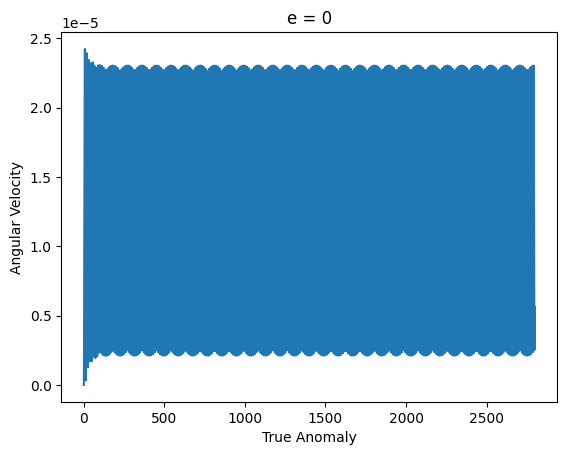

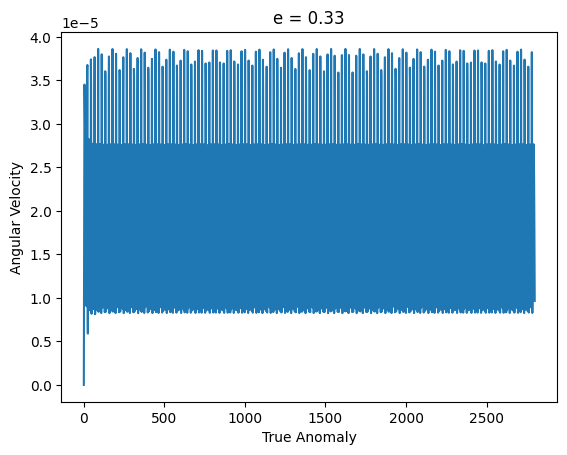

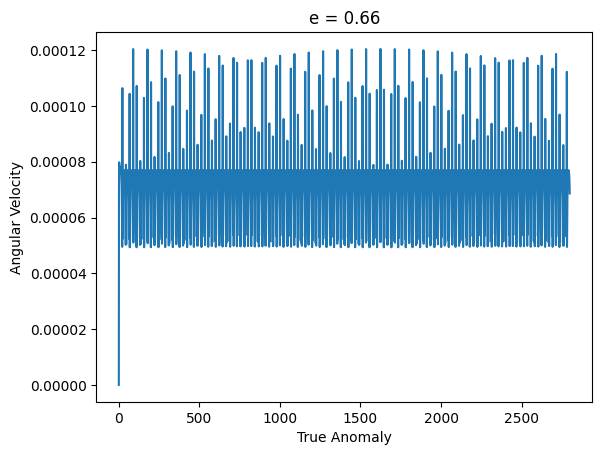

In [8]:
A = 0.4
B = 0.5 #a super funky lookin shape
C = 0.6
a = 38440000 #moved one order of magnitude closer
eccentricity = [0, 0.33, 0.66]
for i in range(3):
    e = eccentricity[i]
    sol = integrate.odeint(func=ODE, y0=state_naught, t=np.linspace(0, T, sampleNumber), args=(G, M, a, e, A, B, C))
    Mean_Anomaly = np.sqrt(G * M / a**3) * np.linspace(0, T, sampleNumber)
    E = findEccentericAnomaly(Mean_Anomaly, e)
    nu_array = np.unwrap(2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), np.sqrt(1 - e) * np.cos(E/2)))
    nu_array = nu_array * 180 / np.pi #degree conversion

    angularvelocities = np.sqrt(np.sum(np.pow(sol[:, 0:3], 2), axis=1))
    
    plt.figure()
    plt.title(f"e = {eccentricity[i]}")
    plt.xlabel("True Anomaly")
    plt.ylabel("Angular Velocity")
    #plt.xticks(np.arange(90, 360 * numOrbits, 90))
    plt.plot(angularvelocities)
    plt.show() 

#better graphs, 
#use hyperion graphs
#try to reproduce graphs
#integrate over more orbits
#look for evidence of chaos in some displayable regime
#edge up to these graphs



Hm. Chaos!

Chaos more likely at lower semi-major axis and higher eccentricity. And of course for more irregular shapes too. 

Where do the equations in `findOrbitalRadius` come from?


$ l = $ semi-lactus rectum (vertical distance between focus and ellipse) <br>
$r = $ satellite distance from focus <br>
$e = $ eccentricity  <br>
$\nu = $ true anomaly (angle between eccentricity vector and satellite) <br>
$$\frac{l}{r} = 1 + e*cos(\nu)$$

$$ r = \frac{l}{1 + e*cos(\nu)} $$

$e$ and $l$ are constant, so we must inject time dependency from $\nu$:
$$ \dot{\nu} = \frac{h}{r^2(\nu)}$$


Where $h$ is the angular momentum per unit mass of a body, and we have $r^2(\nu)$ because the distance of the satellite depends on how fast the $\nu$ changes. This is not integrateable without knowing $r(\nu)$ so we have to play around with it.

Furthermore, the relation follows directly from the conservation of angular momentum: 
In a Keplerian Orbit, angular momentum is conserved, and since $L$ is a scalar multiple of $h$ , $h$ is conserved too. 

So we progress by defining an auxillary circle. The auxillary circle shares the same radius as the semi-major axis of the ellipse. Define the eccentric anomaly, $E$ as the angle made between the origin (not the focus), the positive $x$-axis, and the vertical projection of the position of the satellite onto the auxillary ellipse. 

![alt text](auxdiagram.gif "Diagram")

https://www.akiti.ca/KeplerEquation.html

$$cos(E) = \frac{adjacent}{hypotenuse}$$
Let $P_0$ be the projection of $P$ onto the $x$-axis. 
Then, 
$$cos(E) = \frac{\overline{Of} - \overline{fP_0}}{\overline{OP_c}}$$
$$= \frac{ae + r*cos(\nu)}{a}$$
Because in the diagram, $cos(\nu)$ is negative. 
The motivating step to come up with this yourself would be to draw the diagram with multiple orbital positions and see what remains the same, what changes, and what relationships can be ascertained. Essentially, playing around. 

$$ cos(E) = \frac{ae + r*cos(\nu)}{a} $$

Through
$$tan(\frac{E}{2}) = -\frac{1 - cos(E)}{1 + cos(E)}$$ $$r = \frac{l}{1 + e*cos(\nu)}$$  $$ l = a(1-e^2)$$
and and a lot of algebra rather than trig, 
one finds that:
$$ tan(\frac{E}{2}) = \sqrt{\frac{1-e}{1+e}}tan(\frac{\nu}{2}) $$

$$\frac{r}{a} = \frac{1 - e^2}{1 + e*cos(\nu)} = 1 - e*cos(E) $$
by substituting for $l$, and algebra with the relations  $cos(E) = \frac{ae + r*cos(\nu)}{a}$ and $cos(\nu) = \frac{a(1-e^2)-r}{re} $. 

Then, we differentiate. Why? Because our relationship is dubbed in terms of $\dot{\nu}$ rather than just $\nu $. Furthermore, we can't work with the quantity $\frac{dr}{dt}$, as we defined $r$ as a function of $\nu$. So, we would have to find an intermediary to cancel out the $\frac{dr}{dt}$'s-- which is exactly what we do by equating the above three relations. 

Doing so, 

$$ \frac{\dot{r}}{a} = \frac{(1 - e^2) (-e*sin(\nu)) (\dot{\nu})}{(1 + e*cos(\nu))^2} = e*sin(E)*\dot{E}$$

We hope to find some substitutions and eliminations, and we do!

$$ \frac{\dot{r}}{a} = \frac{r}{a} * \frac{-sin(\nu) (\dot{\nu})}{(1 + e*cos(\nu))} = sin(E)*\dot{E}$$

We take a quick aside:

$$dA = \frac{r^2 d\nu}{2} \implies \dot{A} = \frac{r^2 \dot{\nu}}{2} = const. $$
dividing by $dt$, and because we have $r(\nu)$ not $r(t)$. 

$$A = \pi  a^2\sqrt{1-e^2} \implies \dot{A} = \frac{\pi a^2\sqrt{1-e^2}}{T_p} $$

Because an area $A$ is swept out at a constant rate. Or, integrate the right hand side from $0$ to $A$ and over one period $T_p$ where $T_p$ is the time for the satellite to complete one orbit about the planet. 

Define $n = \frac{2\pi}{T_p}$. 

By Kepler's Third Law, 
$$ n = \frac{2\pi}{T_p} = \sqrt{\frac{GM}{a^3}} = \sqrt{\frac{\mu}{a^3}} $$

Re-Equating terms, 

$$ r^2 \dot{\nu} = na^2\sqrt{1-e^2} \implies \dot{\nu} = \frac{na^2\sqrt{1-e^2}}{r^2}$$

Here, we end the aside and substitute in for $\dot{\nu}$.

$$ \frac{r}{a} * \frac{-sin(\nu) (\frac{na^2\sqrt{1-e^2}}{r^2})}{(1 + e*cos(\nu))} = sin(E)*\dot{E} $$

We may find ourselves in a worse position, but a lot simplifies by substitution in another $\frac{r}{a}$ by getting rid of the nasty denominator:

$$ \frac{r^2}{a^2} * \frac{-a^2nsin(\nu) \sqrt{1-e^2}} {r^2(1 - e^2)} = sin(E)*\dot{E} \implies   \frac{nsin(\nu)} {\sqrt{1-e^2}} = sin(E)*\dot{E}$$






All we need now is to substitute for $sin(\nu)$. Such a substitution can be found utilizing:

$$ tan(\frac{\theta}{2}) = \frac{sin(\theta)}{1 + cos{\theta}} $$


$$ cos(E) = \frac{ae + r*cos(\nu)}{a} $$


$$ tan(\frac{E}{2}) = \sqrt{\frac{1-e}{1+e}}tan(\frac{\nu}{2}) $$

So, we find: 

$$sin(\nu) = \frac{sin(E)\sqrt{1-e^2}}{1-e*cos(E)}$$

After all this work, 

$$ \frac{nsin(\nu)} {\sqrt{1-e^2}} = sin(E)*\dot{E} $$
$$ \frac{n \frac{sin(E)\sqrt{1-e^2}}{1-e*cos(E)}} {\sqrt{1-e^2}} = sin(E)*\dot{E} $$

$$ \frac{n}{1-e*cos(E)} = \dot{E} = \frac{dE}{dt}$$

$$ n\int{}{}{ dt} = \int{}{}{1-e*cos(E) dE}$$

We integrate from time $t_0$ to $t$ and from $E_0$ to $E$, where $E_0$ represents the eccentric anomaly at $t_0$. 

The final formula gives us: 

$$ n (t - t_0) = E - e*sin(E) - (E_0 - e*sin(E_0)) $$

For the purposes of computer representation, $t_0 = 0$ simplifies calculations. All that remains is for an $E_0$ to be chosen for an arbitrary position. The best way to do this is to choose a spot along the elliptical orbit, measure the true anomaly $\nu$ (likely using the angle between the position vector of the satellite and the eccentricity vector while taking the focus as the origin), and relate it to the eccentric anomaly $E$ using our favorite $$tan(\frac{E}{2}) = \sqrt{\frac{1-e}{1+e}}tan(\frac{\nu}{2})$$

If starting at an arbitrary position doesn't matter, take $t_p = 0$ and $E = 0$, corresponding to setting the temporal origin when the satellite just passes its periapsis. 

The quantity $ n ( t - t_p) $ is often defined as the mean anomaly, $M_e$. 
We have $M_e = n ( t - t_p) = 2 \pi * \frac{\delta t}{T_p}$. It doesn't represent anything physical, but can be interpreted as a rough measure of how much the satellite has progressed around its orbit.  

<br>

The important relationships used in code are as follows: <br> <br>
Using $E$, 
$$\frac{r}{a} = 1 - e*cos(E) $$

With $E$, $\nu$ may be found, from which the direction vector locating the satellite may be found. This vector is has components 
$$\hat{r} = cos(\nu)\hat{i} + sin(\nu)\hat{j} + 0\hat{k} $$
When choosing a coordinate system alligned to the orbital plane of the satellite. 
All external torques exerted on the satellites must originate from the perturbing body, and can only lie in this plane. Thus, the orbit remains planar in the case of undamped motion. 

In the case of damped motion, the damping is the result of mass flow due to the force exerted by the perturbing body. Since the $\hat{F_g}$ will always lie inside the orbital plane, the COM of the satellite will also lie inside the orbital plane. Thus, under a properly alligned coordinate system, the above vector relation holds. 

If including radiation pressure or another attracting body, a new equation for $\hat{r}$ will need to be derived. 

The following paragraph details, in a way that makes sense to me at least, proof-creating strategies that made the above problem possible.

We want to find the location of the satellite as well as the direction vector locating the satellite as a function of time. 

If we don't already have a way to relate any of our multitude of angular variables to time, the second best way will likely be to pick an equation with multiple constants we like, and as few variables as possible. We will take the time derivative of this, make some substitutions, and integrate. It doesn't matter if the integral is elementary or if the final equation is trancendental-- the computers can handle it :). 

We start by relating the orbital distance to the true anomaly. Both change in time, but for our purpose, we let $r$ change with $\nu$ and $\nu$ change with $t$. 

We don't have an easy thing to plug-and-chug, as the relationship between true anomaly and orbital distance technically involves a differential equation we can't solve unless we know $r(\nu)$. 

But we don't want to call it quits. 
"The problem would be easy with a circular orbit!" we imagine. So, we do just that. We create a circular orbit, the auxillary circular orbit, and create mappings between the elliptical orbit and the circular orbit. 

Now we want to find ways to map quantities between the two orbits, and hopefully use quantities associated with the circular orbit (such as $E$) as intermediaries in our ultimate goal. 

This ends up being more fruitful. We find two intermediary relations by messing around with geometry and some angles we might find utility in. We define the eccentric anomaly, $E$, and find $E$ as a function of $r$ and $\nu$, and $E$ as a function of $\nu$. From the definition of an ellipse, we also have $r$ as a function of $\nu$. Finally, we have $\dot{\nu}$ as a function of r. 

At this point, our tool box allows us: 

$$cos(E) = f(r, \nu)$$
$$tan(E/2) = g(tan(\nu/2))$$
$$cos(E) = g^{*}(cos(\nu))$$
$$sin(E) = g^{**}(sin(\nu))$$
$$r = h(\nu) $$
$$ \dot{\nu} = j(r)$$

Wait. With this box, we can already eliminate $r$ and get an equation relating $\dot{\nu}$ and $\nu$. That just gives us a single variable differential equation. What's all that Kepler Equation junk for? 

Well, if you carry out the substitutions, you get the following differential equation:
$$ \int_{v_0}^{v}{\frac{d\nu}{(1 + e*cos(\nu))^2}} = \int_{t_0}^{t}{\frac{dt}{a^2(1-e^2)^2}} $$

It isn't closed form, so you'll have to use an approximation for this one too. And you get to skip all that eccentric anomaly junk! 
I don't know why this isn't used. I'd assume it's because the other method has less error or is less computationally intensive. But anyways, here's a cute little result. You can solve this entire mess using just $\frac{l}{r} = 1 + e*cos(\nu)$ and $\dot{\nu} = \frac{na^2\sqrt{1-e^2}}{r^2}$. 

But you notice this is slow, so you keep progressing. Instead of solving it this way, you choose to differentiate instead, getting:

$$ -E*sin(E) = k(r, \dot{r}), \nu, \dot{\nu} $$

But you can make some substitutions: 

$$-E*sin(E) = k(r, \dot{r}, \nu, \dot{\nu}) = k(h(\nu), \frac{dh(\nu)}{dt}, \nu, j(h(\nu))) $$

With that $\frac{dh(\nu)}{dt}$ carrying even more $\nu's$ and $\dot{\nu}$'s. As a lazy mathematician, you try to do this another way. You use the first equation to find a $ r = f^{*}(E, \nu) $ and equate $h(\nu) = f^{*}(E, \nu)$. Your time derivatives will now be more useful, allowing you to differentiate for an $\dot{E}$ and to substitute and cancel away $\nu$'s and $\dot{\nu}$'s. Finally, you integrate and use the final transcendental equation and the equations you found along the way to eventually get the functions of time you wanted.  


<h1>Quaternions</h1>

As for Quaternions, I will only go over the conceptual knowledge needed. 

They are useful because, in the equation to find the torque $\tau$ acting upon the body, we require the direction cosines in the rotating frame of the vector connecting the satellite to the perturbing body. 

Euler angles are usable, but we employ quaternions. 

First, we find the vector $\hat{r}$ connecting the satellite to the perturbing body. Then, we negate $\hat{r} \implies -\hat{r}$ to find the perturbing body relative to the satellite. 

We encode this information in a location quaternion, $\rho = (0, -\hat{r})$. 

At any time $t$, the orientation of the satellite frame is the rotation of the inertial frame about some vector by some angle. This information is incoded into quaternion $q$. So, to rotate from $-\hat{r}$ in the global frame to $-\hat{r}$ in the body frame, we perform the following operation: $\rho ' = q^* \rho q$ We now extract the relavant vector coordinates $\hat{r}' = (x', y', z')$ from $\rho ' = (0, x', y', z')$. Using the definition of the dot product of the basis vectors with a unit vector, we find $\hat{r}'$ already contains the relevant direction cosines needed. 


<h1>Everything Else </h1>

The equation for quaternion time derivatives follows from quaternion calculus and finding the instantaneous quaternion time derivative provided you know the instantaneous angular velocity and instantaneous quaternion. 

The equation for angular velocities follows from basic Lagrangian Mechanics with the body system as the coordinate system. 